In [35]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Ìè∞Ìä∏ Í¥ÄÎ†® Í≤ΩÍ≥† Î©îÏãúÏßÄ Ïà®Í∏∞Í∏∞
warnings.filterwarnings("ignore", category=UserWarning)
mpl.rcParams['font.family'] = 'sans-serif'

In [36]:
import os

os.path.abspath(os.curdir)

'/Users/mac/Documents/GitHub/python-training'

In [37]:
cur_dir = os.path.abspath(os.curdir)
data_dir = f"{cur_dir}/Modulabs_MainProject5"
files = [
    "orders.csv",
    "order_products__train.csv",
    "order_products__prior.csv",
    "df_products.csv"
]

df_orders, df_train, df_prior, df_products = [pd.read_csv(f"{data_dir}/{file}") for file in files]

### 1. ÏÇ¨Ïö©Ïûê Íµ¨Îß§ Ìå®ÌÑ¥ Í∏∞Î∞ò PCA + ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ

In [38]:
df_orders["days_since_prior_order"] = df_orders["days_since_prior_order"].fillna(999)


In [39]:
# -------------------------
# 1. ÏÇ¨Ïö©Ïûê Íµ¨Îß§ Ìå®ÌÑ¥ Í∏∞Î∞ò PCA + ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
# -------------------------


# ‚úÖ 999Ïù∏ days_since_prior_order Í∞í Ï†úÏô∏
df_orders_filtered = df_orders[df_orders["days_since_prior_order"] != 999]

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÎ¨∏ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
user_order_stats = df_orders_filtered.groupby("user_id").agg({
    "order_number": "max",  # Ï¥ù Ï£ºÎ¨∏ ÌöüÏàò
    "days_since_prior_order": "mean"  # ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©
})

# ‚úÖ df_priorÏóê user_id Ï∂îÍ∞Ä (df_ordersÏôÄ Î≥ëÌï©)
ddf_prior = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïû¨Íµ¨Îß§Ïú® Í≥ÑÏÇ∞ (user_id Í∏∞Ï§Ä)
user_reorder_stats = ddf_prior.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© (user_id Í∏∞Ï§Ä)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ ÌëúÏ§ÄÌôî
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id Ï†úÏô∏

# ‚úÖ PCA Ï†ÅÏö© (Ï∞®Ïõê Ï∂ïÏÜå)
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_features_scaled)

# ‚úÖ K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏµúÏ†ÅÌôî: n_clusters=3,4,5 ÎπÑÍµê
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ‚úÖ ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏÑ†ÌÉù (Í∏∞Î≥∏Ï†ÅÏúºÎ°ú n=4 ÏÇ¨Ïö©)
selected_k = 4
user_clusters = cluster_results[selected_k]

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû•
user_features["cluster"] = user_clusters

# ‚úÖ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
plt.scatter(user_pca[:, 0], user_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"User Purchase Pattern Clustering (K={selected_k})")
plt.colorbar(label="Cluster")
plt.show()

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º ÌôïÏù∏
user_clusters


array([0, 0, 0, ..., 0, 2, 0], shape=(206209,), dtype=int32)

### **üîç ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º Ìï¥ÏÑù**
Ïù¥Ï†ú ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÏù¥ **Ïù¥ÏÉÅÏ†ÅÏù∏ ÌòïÌÉúÎ°ú Í∞úÏÑ†**ÎêòÏóàÏäµÎãàÎã§! üöÄ  
PCAÎ°ú Ï∞®Ïõê Ï∂ïÏÜåÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏãúÍ∞ÅÌôîÌïú Í∑∏ÎûòÌîÑÏóêÏÑú **4Í∞úÏùò ÌÅ¥Îü¨Ïä§ÌÑ∞(K=4)**Í∞Ä Ïûò Íµ¨Î∂ÑÎêú Í≤ÉÏùÑ Î≥º Ïàò ÏûàÏäµÎãàÎã§.  

---

### **üìå 1. ÌÅ¥Îü¨Ïä§ÌÑ∞Ïùò Î∂ÑÌè¨**
1. **Î≥¥ÎùºÏÉâ(Cluster 0)**  
   - Ï§ëÏã¨Î∂ÄÏóê Î∂ÑÌè¨ÌïòÎ©∞ Îã§Î•∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ÏôÄÏùò Í≤ΩÍ≥Ñ Ïó≠Ìï†ÏùÑ Ìï®  
   - ÌèâÍ∑†Ï†ÅÏù∏ Íµ¨Îß§ Ìå®ÌÑ¥ÏùÑ Í∞ÄÏßÑ ÏÇ¨Ïö©Ïûê Í∑∏Î£πÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå  

2. **Ï≤≠Î°ùÏÉâ(Cluster 1)**  
   - Ïò§Î•∏Ï™ΩÏúºÎ°ú ÎÑìÍ≤å ÌçºÏ†∏ ÏûàÏùå ‚Üí **PC1 Í∞íÏù¥ ÎÜíÏùå (Ï£ºÎ¨∏ ÌöüÏàò, Ïû¨Íµ¨Îß§Ïú® ÎÜíÏùÑ Í∞ÄÎä•ÏÑ±)**  
   - **ÏûêÏ£º Íµ¨Îß§ÌïòÎäî Í≥†Í∞ùÏ∏µ**Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº (VIP Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±)  

3. **ÌååÎûÄÏÉâ(Cluster 2)**  
   - ÏôºÏ™Ω ÏÉÅÎã®Ïóê ÏúÑÏπò ‚Üí **PC1Í≥º PC2Í∞Ä ÏùåÏàòÏù∏ ÏòÅÏó≠**  
   - Íµ¨Îß§ ÌöüÏàòÍ∞Ä Ï†ÅÍ±∞ÎÇò, ÌäπÏ†ï ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóêÎßå Ï£ºÎ¨∏ÌïòÎäî Ìå®ÌÑ¥ÏùÑ Î≥¥Ïùº Ïàò ÏûàÏùå  

4. **ÎÖ∏ÎûÄÏÉâ(Cluster 3)**  
   - ÏôºÏ™Ω ÌïòÎã®ÏúºÎ°ú ÌôïÏû•Îê® ‚Üí **PC1Ïù¥ ÎÇÆÍ≥†, PC2ÎèÑ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÇÆÏùå**  
   - Íµ¨Îß§ ÎπàÎèÑÍ∞Ä ÎÇÆÍ±∞ÎÇò, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùÄ Í∑∏Î£πÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå (Ïã†Í∑ú ÏÇ¨Ïö©Ïûê Ìè¨Ìï® Í∞ÄÎä•)  

---

### **üìä 2. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ìï¥ÏÑù**
- **PC1 (XÏ∂ï)** ‚Üí `Ï£ºÎ¨∏ ÌöüÏàò`, `Ïû¨Íµ¨Îß§Ïú®` Îì±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº  
  - Ïò§Î•∏Ï™ΩÏúºÎ°ú Í∞àÏàòÎ°ù **ÏûêÏ£º Ï£ºÎ¨∏ÌïòÎäî Í≥†Í∞ù**  
  - ÏôºÏ™ΩÏùºÏàòÎ°ù **Ï£ºÎ¨∏ ÌöüÏàòÍ∞Ä Ï†ÅÍ±∞ÎÇò, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùå**  
- **PC2 (YÏ∂ï)** ‚Üí `Ï£ºÎ¨∏ ÏãúÍ∞ÑÎåÄ`, `ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©` Îì±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº  
  - ÏúÑÏ™Ω(ÏñëÏàò) ‚Üí ÌäπÏ†ï ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóê Î™∞Î†§ Íµ¨Îß§ÌïòÎäî Í≥†Í∞ù  
  - ÏïÑÎûòÏ™Ω(ÏùåÏàò) ‚Üí Ï£ºÎ¨∏ ÏãúÍ∞ÑÏù¥ ÏùºÏ†ïÌïòÏßÄ ÏïäÍ±∞ÎÇò, Í∞ÑÍ≤©Ïù¥ Î∂àÍ∑úÏπôÌïú Í≥†Í∞ù  

---

### **‚úÖ Í≤∞Î°†**
- **Cluster 1 (Ï≤≠Î°ùÏÉâ) ‚Üí VIP Í≥†Í∞ù**  
  - Ï£ºÎ¨∏ ÌöüÏàòÏôÄ Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÜíÏùÄ ÌïµÏã¨ Í≥†Í∞ùÏ∏µ  
  - Ïù¥ Í∑∏Î£πÏùÑ ÎåÄÏÉÅÏúºÎ°ú **Ï∂©ÏÑ± Í≥†Í∞ù Ïú†ÏßÄ Ï†ÑÎûµ (Î°úÏó¥Ìã∞ ÌîÑÎ°úÍ∑∏Îû®, Ï∂îÏ≤ú ÏÉÅÌíà Ï†úÍ≥µ Îì±)**ÏùÑ Í≥†Î†§ Í∞ÄÎä•  

- **Cluster 3 (ÎÖ∏ÎûÄÏÉâ) ‚Üí Ïã†Í∑ú Í≥†Í∞ù or ÎÇÆÏùÄ Íµ¨Îß§ ÎπàÎèÑ Í≥†Í∞ù**  
  - Íµ¨Îß§ ÌöüÏàòÍ∞Ä Ï†ÅÍ±∞ÎÇò Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùå  
  - Ïù¥Îì§ÏùÑ ÎåÄÏÉÅÏúºÎ°ú **Ìï†Ïù∏ Ïø†Ìè∞, ÌîÑÎ°úÎ™®ÏÖò Ï†úÍ≥µ Îì± Ïû¨Íµ¨Îß§ Ïú†ÎèÑ Ï†ÑÎûµ** ÌïÑÏöî  

- **Cluster 2 (ÌååÎûÄÏÉâ) ‚Üí ÌäπÏ†ï Ìå®ÌÑ¥ Íµ¨Îß§ Í≥†Í∞ù**  
  - ÌäπÏ†ï ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóêÎßå Ï£ºÎ¨∏ÌïòÎäî Í≤ΩÌñ•  
  - Ï£ºÎßê ÎòêÎäî ÌäπÏ†ï ÏãúÍ∞ÑÎåÄ(ÏïºÍ∞Ñ/Ïò§Ï†Ñ)Ïóê ÏßëÏ§ëÏ†ÅÏúºÎ°ú ÎßàÏºÄÌåÖ Í∞ÄÎä•  

- **Cluster 0 (Î≥¥ÎùºÏÉâ) ‚Üí ÏùºÎ∞òÏ†ÅÏù∏ Í≥†Í∞ù**  
  - Í∑πÎã®Ï†ÅÏù¥ÏßÄ ÏïäÏùÄ ÏùºÎ∞òÏ†ÅÏù∏ Íµ¨Îß§ Ìå®ÌÑ¥ÏùÑ Í∞ÄÏßÑ Í∑∏Î£π  
  - ÌïµÏã¨ Í≥†Í∞ùÏúºÎ°ú ÏÑ±Ïû•Ìï† Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÎäî Í∑∏Î£π  

---



### **üìå PCAÏóêÏÑú XÏ∂ï(PC1)Í≥º YÏ∂ï(PC2)Ïùò ÏùòÎØ∏ ÏÑ§Î™Ö**  

1. **PCA(Ï£ºÏÑ±Î∂Ñ Î∂ÑÏÑù)Îäî Îç∞Ïù¥ÌÑ∞Ïùò Ï∞®ÏõêÏùÑ Ï∂ïÏÜåÌïòÎ©¥ÏÑú Í∞ÄÏû• Ï§ëÏöîÌïú Ï†ïÎ≥¥(Î∂ÑÏÇ∞Ïù¥ ÌÅ∞ Î∞©Ìñ•)Î•º Ïú†ÏßÄÌïòÎäî Í∏∞Î≤ïÏûÖÎãàÎã§.**  
2. **PC1 (XÏ∂ï)ÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í∞ÄÏû• ÎßéÏùÄ Î≥ÄÎèô(Î∂ÑÏÇ∞)ÏùÑ ÏÑ§Î™ÖÌïòÎäî Î∞©Ìñ•Ïù¥Î©∞, PC2 (YÏ∂ï)ÏùÄ Í∑∏Îã§ÏùåÏúºÎ°ú Ï§ëÏöîÌïú Î≥ÄÎèôÏùÑ ÏÑ§Î™ÖÌïòÎäî Ï∂ïÏûÖÎãàÎã§.**  
3. **Ï£ºÎ¨∏ ÌöüÏàò(`order_number`), ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©(`days_since_prior_order`), Ïû¨Íµ¨Îß§Ïú®(`reorder_rate`) Îì±Ïùò Î≥ÄÏàòÎì§Ïù¥ PCAÏóê ÏùòÌï¥ Î≥ÄÌôòÎê©ÎãàÎã§.**  
4. **XÏ∂ï(PC1)Ïù¥ ÌÅ¨Îã§Îäî Í≤ÉÏùÄ Ï£ºÎ¨∏ ÌöüÏàòÍ∞Ä ÎßéÍ±∞ÎÇò, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÜíÏùÄ Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅΩÎãàÎã§.**  
5. **XÏ∂ï(PC1)Ïù¥ ÏûëÎã§Îäî Í≤ÉÏùÄ Ï£ºÎ¨∏ ÌöüÏàòÍ∞Ä Ï†ÅÍ±∞ÎÇò, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùÄ Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅΩÎãàÎã§.**  
6. **YÏ∂ï(PC2)Ïù¥ ÌÅ¨Îã§Îäî Í≤ÉÏùÄ Ï£ºÎ¨∏ Ìå®ÌÑ¥Ïù¥ ÏùºÏ†ïÌïòÍ±∞ÎÇò, ÌäπÏ†ïÌïú ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóê Î™∞Î†§ ÏûàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.**  
7. **YÏ∂ï(PC2)Ïù¥ ÏûëÎã§Îäî Í≤ÉÏùÄ Ï£ºÎ¨∏ Í∞ÑÍ≤©Ïù¥ Î∂àÍ∑úÏπôÌïòÍ±∞ÎÇò, ÌäπÏ†ïÌïú ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóê ÏßëÏ§ëÎêòÏßÄ ÏïäÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏäµÎãàÎã§.**  
8. **Í∑∏ÎûòÌîÑÏóêÏÑú Ïò§Î•∏Ï™Ω(PC1 ÏñëÏàò)Ïóê ÏúÑÏπòÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî Ï∂©ÏÑ±ÎèÑÍ∞Ä ÎÜíÏùÄ Í≥†Í∞ù(ÏûêÏ£º Ï£ºÎ¨∏, Ïû¨Íµ¨Îß§Ïú® ÎÜíÏùå)Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.**  
9. **Í∑∏ÎûòÌîÑÏóêÏÑú ÏôºÏ™Ω(PC1 ÏùåÏàò)Ïóê ÏúÑÏπòÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî Ïã†Í∑ú Í≥†Í∞ù ÎòêÎäî Í∞ÄÎÅî Íµ¨Îß§ÌïòÎäî Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.**  
10. **ÏúÑÏ™Ω(PC2 ÏñëÏàò)Ïóê ÏûàÎäî ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî ÌäπÏ†ïÌïú Ìå®ÌÑ¥ÏùÑ Í∞ÄÏßÑ Í≥†Í∞ù(Ïòà: ÌäπÏ†ï ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóê ÏßëÏ§ëÏ†ÅÏúºÎ°ú Ï£ºÎ¨∏)Ïù¥Í≥†, ÏïÑÎûòÏ™Ω(PC2 ÏùåÏàò)Ïóê ÏûàÎäî ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî Î∂àÍ∑úÏπôÌïú Ï£ºÎ¨∏ Ìå®ÌÑ¥ÏùÑ Í∞ÄÏßÑ Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅΩÎãàÎã§.**  

---

### **üìä Í≤∞Î°†**
PCAÏóêÏÑú **PC1(XÏ∂ï)ÏùÄ Ï£ºÎ°ú "Íµ¨Îß§ ÎπàÎèÑ, Ïû¨Íµ¨Îß§Ïú®"Í≥º Í¥ÄÎ†®Ïù¥ ÏûàÍ≥†**,  
**PC2(YÏ∂ï)Îäî "Ï£ºÎ¨∏ Í∞ÑÍ≤©Ïùò ÏùºÏ†ïÌï®, ÌäπÏ†ï Ìå®ÌÑ¥ Ïó¨Î∂Ä"ÏôÄ Í¥ÄÎ†®Ïù¥ ÏûàÏäµÎãàÎã§.**  
Í∑∏ÎûòÏÑú **XÏ∂ïÏù¥ ÌÅ¨Î©¥ Ï∂©ÏÑ± Í≥†Í∞ù, ÏûëÏúºÎ©¥ Ïã†Í∑ú Í≥†Í∞ù / YÏ∂ïÏù¥ ÌÅ¨Î©¥ ÌäπÏ†ï ÏãúÍ∞Ñ Ìå®ÌÑ¥, ÏûëÏúºÎ©¥ Î∂àÍ∑úÏπôÌïú Í≥†Í∞ù**ÏúºÎ°ú Ìï¥ÏÑùÌï† Ïàò ÏûàÏäµÎãàÎã§. üòä

In [40]:
# PCA Ï†ÅÏö©

# PCA Î™®Îç∏ ÏÉùÏÑ± (Ï∞®Ïõê 2Í∞úÎ°ú Ï∂ïÏÜå)
pca = PCA(n_components=2)

# Î≥ÄÌôò Ï†ÅÏö©
df_pca_transformed = pca.fit_transform(user_features_scaled)

# Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôò
df_pca_result = pd.DataFrame(df_pca_transformed, columns=["PC1", "PC2"])

# Ï£ºÏÑ±Î∂Ñ ÏÑ§Î™ÖÎ†• ÌôïÏù∏ (Í∞Å PCÍ∞Ä ÏÑ§Î™ÖÌïòÎäî Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®)
print("ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®: ", pca.explained_variance_ratio_)

#Í∞í 80ÎÑòÏùå Ïú†ÏùòÎØ∏.

ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®:  [0.70991022 0.1789922 ]


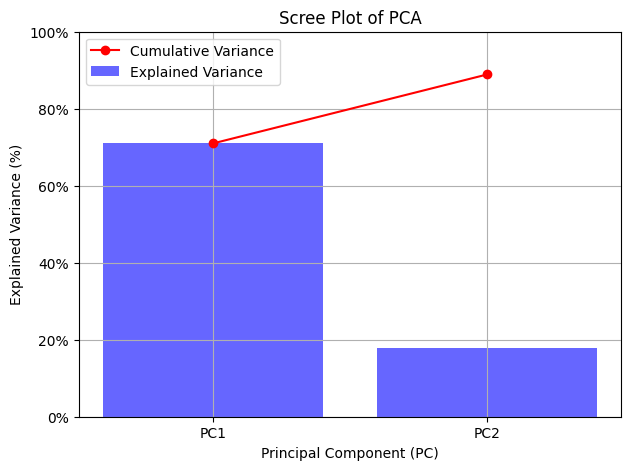

In [41]:
# Retrieve explained variance ratio from PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Compute cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create figure
plt.figure(figsize=(7,5))

# Bar plot for individual explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='b', label="Explained Variance")

# Line plot for cumulative variance
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='r', label="Cumulative Variance")

# Labels and title
plt.xlabel("Principal Component (PC)")
plt.ylabel("Explained Variance (%)")
plt.title("Scree Plot of PCA")
plt.xticks(range(1, len(explained_variance_ratio) + 1), [f"PC{i}" for i in range(1, len(explained_variance_ratio) + 1)])
plt.yticks(np.arange(0, 1.1, 0.2), ["0%", "20%", "40%", "60%", "80%", "100%"])
plt.legend()
plt.grid()

# Show plot
plt.show()

## ÏúÑÏùòÍ≤É Í∑∏ÎûòÌîÑÌôî

In [42]:
# ‚úÖ 1. Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù Ïàò ÌôïÏù∏
cluster_counts = user_features.groupby("cluster").size()
print("Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù Ïàò:")
print(cluster_counts)

# ‚úÖ 2. Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ ÌöüÏàò, Ïû¨Íµ¨Îß§Ïú® Î∂ÑÏÑù
cluster_means = user_features.groupby("cluster").mean()
print("\nÍ∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† Í∞í (Ï£ºÎ¨∏ ÌöüÏàò, Ïû¨Íµ¨Îß§Ïú® Îì±):")
print(cluster_means)


Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù Ïàò:
cluster
0    64460
1    50671
2    25145
3    65933
dtype: int64

Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† Í∞í (Ï£ºÎ¨∏ ÌöüÏàò, Ïû¨Íµ¨Îß§Ïú® Îì±):
               user_id  order_number  days_since_prior_order  reorder_rate
cluster                                                                   
0        102844.396742     18.951598               12.686930      0.576462
1        103216.648339      8.352174               12.773832      0.261549
2        102897.048638     52.516484                6.676457      0.729931
3        103353.283712      6.911911               23.549911      0.308918


### **üîç ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Î∂ÑÏÑù (Íµ¨Îß§ Ìå®ÌÑ¥ ÎπÑÍµê)**  

üìä **1. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù Ïàò Î∂ÑÌè¨**  
- **Cluster 0** (üíú) ‚Üí **64,460Î™Ö (Í∞ÄÏû• ÎßéÏùÄ Í≥†Í∞ùÍµ∞)**  
- **Cluster 1** (üíô) ‚Üí **50,671Î™Ö**  
- **Cluster 2** (üíö) ‚Üí **25,145Î™Ö (Í∞ÄÏû• Ï†ÅÏùÄ Í≥†Í∞ùÍµ∞)**  
- **Cluster 3** (üíõ) ‚Üí **65,933Î™Ö**  

üí° **üëâ ÌÅ¥Îü¨Ïä§ÌÑ∞ 0Í≥º 3Ïù¥ Í∞ÄÏû• ÌÅ∞ Í∑∏Î£πÏù¥Î©∞, ÌÅ¥Îü¨Ïä§ÌÑ∞ 2Îäî Í∞ÄÏû• Ï†ÅÏùÄ Í≥†Í∞ùÏùÑ Ìè¨Ìï®Ìï®**  

---

üìä **2. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ìå®ÌÑ¥**  
| Cluster | ÌèâÍ∑† Ï£ºÎ¨∏ ÌöüÏàò (`order_number`) | ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤© (`days_since_prior_order`) | Ïû¨Íµ¨Îß§Ïú® (`reorder_rate`) |
|---------|----------------|----------------------|------------------|
| **0 (üíú)** | 18.95 Ìöå  | 12.69 Ïùº | **57.6%** |
| **1 (üíô)** | 8.35 Ìöå  | 12.77 Ïùº | **26.1%** |
| **2 (üíö)** | **52.51 Ìöå**  | **6.67 Ïùº** | **72.9%** |
| **3 (üíõ)** | **6.91 Ìöå**  | **23.55 Ïùº** | 30.8% |

üí° **üëâ Î∂ÑÏÑù Ìè¨Ïù∏Ìä∏:**  
1. **Cluster 2 (üíö) ‚Üí Í∞ÄÏû• ÎÜíÏùÄ Ïû¨Íµ¨Îß§Ïú® (72.9%) & Í∞ÄÏû• ÏûêÏ£º Ï£ºÎ¨∏ (6.67Ïùº Í∞ÑÍ≤©)**
   - ÏûêÏ£º Î∞òÎ≥µ Íµ¨Îß§ÌïòÎäî **Î°úÏó¥Ìã∞ ÎÜíÏùÄ Í≥†Í∞ù**  
   - **VIP Í≥†Í∞ùÍµ∞**, Ï†ïÍ∏∞Ï†ÅÏù∏ Íµ¨Îß§ Ìå®ÌÑ¥  

2. **Cluster 3 (üíõ) ‚Üí Í∞ÄÏû• ÎÇÆÏùÄ Ï£ºÎ¨∏ ÌöüÏàò (6.91Ìöå) & Í∞ÄÏû• Í∏¥ Ï£ºÎ¨∏ Í∞ÑÍ≤© (23.55Ïùº)**
   - **Ïã†Í∑ú Í≥†Í∞ù ÎòêÎäî Í∞ÄÎÅî Ï£ºÎ¨∏ÌïòÎäî Í≥†Í∞ù**  
   - Ïù¥ÌÉà Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùÄ Í≥†Í∞ù ‚Üí **Ìï†Ïù∏ Ïø†Ìè∞, Ïû¨Íµ¨Îß§ Ïú†ÎèÑ ÎßàÏºÄÌåÖ ÌïÑÏöî**  

3. **Cluster 0 (üíú) ‚Üí ÌèâÍ∑†Ï†ÅÏù∏ Ï£ºÎ¨∏ Ìå®ÌÑ¥ (18.95Ìöå & 12.69Ïùº)**
   - ÏùºÎ∞òÏ†ÅÏù∏ Í≥†Í∞ù Ìå®ÌÑ¥ÏùÑ Î≥¥Ïù¥Î©∞, Ï†ÅÏ†àÌïú Ïû¨Íµ¨Îß§Ïú®(57.6%) Ïú†ÏßÄ  

4. **Cluster 1 (üíô) ‚Üí Ï£ºÎ¨∏ ÌöüÏàò Ï†ÅÍ≥†, Ïû¨Íµ¨Îß§Ïú®ÎèÑ ÎÇÆÏùå (26.1%)**
   - Í∞ÄÎÅî Ï£ºÎ¨∏ÌïòÎäî Í≥†Í∞ù, ÌäπÏ†ï ÏãúÏ¶åÏóêÎßå Íµ¨Îß§Ìï† Í∞ÄÎä•ÏÑ±  
   - **ÌôúÏÑ±ÌôîÎ•º ÏúÑÌïú ÎßûÏ∂§ ÎßàÏºÄÌåÖ ÌïÑÏöî**  

---

### **üìå Í≤∞Î°† Î∞è Ïù∏ÏÇ¨Ïù¥Ìä∏**
1Ô∏è‚É£ **Cluster 2 (üíö) VIP Í≥†Í∞ù**  
   - Ï£ºÎ¨∏ ÌöüÏàò ÎßéÍ≥†, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÜíÏùå ‚Üí **Íµ¨ÎèÖ ÏÑúÎπÑÏä§, Î©§Î≤ÑÏã≠ Ï†úÍ≥µ Í≥†Î†§**  

2Ô∏è‚É£ **Cluster 3 (üíõ) Ïã†Í∑ú ÎòêÎäî Ïù¥ÌÉà ÏúÑÌóò Í≥†Í∞ù**  
   - Ï£ºÎ¨∏ ÌöüÏàò Ï†ÅÍ≥†, Ï£ºÎ¨∏ Í∞ÑÍ≤© ÍπÄ ‚Üí **Ïø†Ìè∞ Ï†úÍ≥µ, Ïû¨Íµ¨Îß§ Ïú†ÎèÑ Ï∫†ÌéòÏù∏ ÌïÑÏöî**  

3Ô∏è‚É£ **Cluster 1 (üíô) ÎπÑÌôúÏÑ± Í≥†Í∞ù**  
   - Ïû¨Íµ¨Îß§Ïú® ÎÇÆÍ≥† Ï£ºÎ¨∏ ÌöüÏàò Ï†ÅÏùå ‚Üí **ÎßûÏ∂§Ìòï ÏÉÅÌíà Ï∂îÏ≤ú, Ïù¥Î©îÏùº ÎßàÏºÄÌåÖ ÌôúÏö©**  

4Ô∏è‚É£ **Cluster 0 (üíú) ÏùºÎ∞ò Í≥†Í∞ù**  
   - Íæ∏Ï§ÄÌïú Íµ¨Îß§Î•º Ïú†ÏßÄÌïòÎäî ÌïµÏã¨ Í≥†Í∞ùÍµ∞  

---

### **üí° Ï∂îÍ∞Ä Î∂ÑÏÑù Í∞ÄÎä• Ìè¨Ïù∏Ìä∏**
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Íµ¨Îß§ Ï†úÌíà Î∂ÑÏÑù (Ïñ¥Îñ§ Ï†úÌíàÏùÑ Ï£ºÎ°ú Íµ¨Îß§?)**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ/ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥ Î∂ÑÏÑù**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ïó∞Î†πÎåÄ, ÏßÄÏó≠ Îì± Ï∂îÍ∞ÄÏ†ÅÏù∏ Í≥†Í∞ù ÌäπÏÑ± Î∂ÑÏÑù Í∞ÄÎä•**  

üìä Ï∂îÍ∞Ä Î∂ÑÏÑùÏù¥ ÌïÑÏöîÌïòÎ©¥ ÏïåÎ†§Ï£ºÏÑ∏Ïöî! üòä

In [43]:
# department Í∏∞Ï§Ä
# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Íµ¨Îß§ Ï†úÌíà Î∂ÑÏÑù (Ïñ¥Îñ§ Ï†úÌíàÏùÑ Ï£ºÎ°ú Íµ¨Îß§?)
# df_priorÏôÄ df_productsÎ•º Í≤∞Ìï©ÌïòÏó¨ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï†úÌíà Íµ¨Îß§ Î∂ÑÏÑù
dddf_prior = ddf_prior.merge(df_products[['product_id', 'product_name', 'department_id', 'aisle_id']], on='product_id', how='left')
dddf_prior = dddf_prior.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥ÑÎ°ú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Ìïú Ï†úÌíà ÏÉÅÏúÑ 10Í∞ú
cluster_top_products = dddf_prior.groupby(['cluster', 'product_name']).size().reset_index(name='count')
cluster_top_products = cluster_top_products.sort_values(['cluster', 'count'], ascending=[True, False])
print(cluster_top_products.groupby('cluster').head(10))

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ/ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥ Î∂ÑÏÑù
dddf_orders = df_orders.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ïàò Í≥ÑÏÇ∞
cluster_order_dow = dddf_orders.groupby(['cluster', 'order_dow']).size().reset_index(name='count')
print(cluster_order_dow)

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ïàò Í≥ÑÏÇ∞
cluster_order_hour = dddf_orders.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
print(cluster_order_hour)


        cluster            product_name   count
3561          0                  Banana  177276
3362          0  Bag of Organic Bananas  132622
27992         0    Organic Baby Spinach   91111
31025         0    Organic Strawberries   90490
29435         0    Organic Hass Avocado   74392
27956         0         Organic Avocado   69573
21752         0             Large Lemon   58780
41700         0            Strawberries   54031
22736         0                   Limes   52762
31571         0      Organic Whole Milk   46713
51702         1                  Banana   39455
51509         1  Bag of Organic Bananas   25744
75291         1    Organic Baby Spinach   19145
78235         1    Organic Strawberries   17648
75257         1         Organic Avocado   17094
69255         1             Large Lemon   16854
70196         1                   Limes   14359
76683         1    Organic Hass Avocado   14184
88597         1            Strawberries   13738
94602         1           Yellow Onions 

### **üîç ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Î∂ÑÏÑù (Ï†úÌíà Íµ¨Îß§ & Ï£ºÎ¨∏ Ìå®ÌÑ¥ ÎπÑÍµê)**  

#### **üìå 1. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥ÑÎ°ú ÎßéÏù¥ Íµ¨Îß§Ìïú Ï†úÌíà TOP 10**  
‚úÖ **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§ÌïòÎäî Ï†úÌíàÏùÄ Ïã†ÏÑ†ÏãùÌíà(Í≥ºÏùº, Ï±ÑÏÜå, Ïú†Ï†úÌíà)Ïù¥Îã§.**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2Í∞Ä Í∞ÄÏû• ÎßéÏùÄ ÏàòÎüâÏùÑ Íµ¨Îß§ÌïòÎ©∞, Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Ïú†Í∏∞ÎÜç Ï†úÌíà ÏÑ†Ìò∏ÎèÑÍ∞Ä ÎÜíÎã§.**  

| Cluster | Ï†úÌíà | Íµ¨Îß§Îüâ |
|---------|-------------|----------|
| **0 (üíú)** | Banana | **177,276** |
| **1 (üíô)** | Banana | **39,455** |
| **2 (üíö)** | Banana | **202,023** |
| **3 (üíõ)** | Banana | **53,811** |

**üí° Ìï¥ÏÑù:**  
- **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú "Banana(Î∞îÎÇòÎÇò)"Í∞Ä 1ÏúÑÎ°ú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Îê®.**  
- **Ïú†Í∏∞ÎÜç Ï†úÌíà(Organic Baby Spinach, Organic Hass Avocado, Organic Strawberries Îì±)Ïùò Ïù∏Í∏∞Í∞Ä ÎÜíÏùå.**  
- **Cluster 2(üíö)Îäî Ïú†Í∏∞ÎÜç Ï†úÌíàÏùÑ Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§ÌïòÎ©∞, Ï∂©ÏÑ± Í≥†Í∞ùÏ∏µÏù¥ ÎßéÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº.**  
- **Cluster 3(üíõ)Îäî Ïò§Ïù¥(Cucumber Kirby)Î•º ÏÉÅÏúÑ 10ÏúÑ ÎÇ¥Ïóê Ìè¨Ìï®Ìïú Ïú†ÏùºÌïú Í∑∏Î£π ‚Üí ÌäπÏ†ïÌïú ÏÜåÎπÑ Ìå®ÌÑ¥ÏùÑ Î≥¥Ïùº Í∞ÄÎä•ÏÑ± ÏûàÏùå.**  

---

#### **üìå 2. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥**
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞ 0(üíú) & ÌÅ¥Îü¨Ïä§ÌÑ∞ 2(üíö)Îäî Ï£ºÎßê(ÌÜ†, Ïùº)Ïóê Ï£ºÎ¨∏Ïù¥ ÏßëÏ§ëÎê®.**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞ 1(üíô) & ÌÅ¥Îü¨Ïä§ÌÑ∞ 3(üíõ)Îäî ÌèâÏùº(Ïõî~Í∏à)Ïóê Îçî ÎßéÏù¥ Ï£ºÎ¨∏ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏùå.**  

**üí° Ìï¥ÏÑù:**  
- **Cluster 2(üíö)Îäî ÏùºÏöîÏùº(234,370Í±¥) Ï£ºÎ¨∏Ïù¥ Í∞ÄÏû• ÎßéÏúºÎ©∞, Ï£ºÎßêÏóê ÏßëÏ§ëÏ†ÅÏúºÎ°ú Ï£ºÎ¨∏ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏùå.**  
- **Cluster 0(üíú) Ïó≠Ïãú Ï£ºÎßêÏóê Ï£ºÎ¨∏ÎüâÏù¥ ÎßéÏúºÎ©∞, Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Ï£ºÎ¨∏ÎüâÏù¥ ÎÜíÏùÄ Í∑∏Î£πÏù¥Îã§.**  
- **Cluster 1(üíô)Í≥º Cluster 3(üíõ)Îäî Ïõî~Í∏à(ÌèâÏùº)Ïóê Ï£ºÎ¨∏Ïù¥ ÎßéÏù¥ Ïù¥Î£®Ïñ¥ÏßÄÎ©∞, ÏóÖÎ¨¥ Ìå®ÌÑ¥Í≥º Í¥ÄÎ†® ÏûàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.**  
- **Ï¶â, Cluster 2(üíö)ÏôÄ Cluster 0(üíú)Îäî Ï£ºÎßê ÎßûÏ∂§Ìòï Ìï†Ïù∏/ÌîÑÎ°úÎ™®ÏÖòÏù¥ Ìö®Í≥ºÏ†ÅÏù¥Í≥†, Cluster 1(üíô)Í≥º Cluster 3(üíõ)Îäî ÌèâÏùº ÎßûÏ∂§Ìòï Ï∫†ÌéòÏù∏Ïù¥ Ïú†Ìö®Ìï† Ïàò ÏûàÏùå.**  

---

#### **üìå 3. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥**  
‚úÖ **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú Ïò§Ï†Ñ 10~11Ïãú Ï£ºÎ¨∏ÎüâÏù¥ Í∞ÄÏû• ÎßéÏùå.**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2(üíö)Îäî Î∞§ Îä¶Í≤åÍπåÏßÄ Ï£ºÎ¨∏ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏùå.**  

**üí° Ìï¥ÏÑù:**  
- **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú ÏÉàÎ≤Ω 3~6Ïãú Ï£ºÎ¨∏ÎüâÏù¥ Í∞ÄÏû• Ï†ÅÍ≥†, Ïò§Ï†Ñ 10~11ÏãúÏóê Ï£ºÎ¨∏ÎüâÏù¥ Í∏âÏ¶ùÌï®.**  
- **Cluster 2(üíö)Îäî Î∞§ 21~23ÏãúÏóêÎèÑ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÜíÏùÄ Ï£ºÎ¨∏ÎüâÏùÑ Î≥¥Ïù¥Î©∞, Îä¶ÏùÄ ÏãúÍ∞Ñ ÏáºÌïëÏùÑ ÏÑ†Ìò∏ÌïòÎäî Í≥†Í∞ùÏ∏µÏù¥ Ìè¨Ìï®Îê† Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.**  
- **Cluster 3(üíõ)Îäî Ï†ÄÎÖÅ 19~21ÏãúÏóê Ï£ºÎ¨∏ÎüâÏù¥ ÎßéÏïÑ, ÏßÅÏû•Ïù∏ Í≥†Í∞ùÏù¥ Ìè¨Ìï®Îê† Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå.**  
- **Ïù¥ Ï†ïÎ≥¥Î•º Í∏∞Î∞òÏúºÎ°ú ÌäπÏ†ï ÏãúÍ∞ÑÎåÄ ÎßûÏ∂§Ìòï ÌîÑÎ°úÎ™®ÏÖò(Ïòà: "ÏïºÍ∞Ñ Ìï†Ïù∏" ÎòêÎäî "Ï∂úÍ∑º Ï†Ñ Ï£ºÎ¨∏ ÌòúÌÉù")ÏùÑ Í≥†Î†§Ìï† Ïàò ÏûàÏùå.**  

---

### **üìä ÏµúÏ¢Ö Í≤∞Î°† Î∞è Ïù∏ÏÇ¨Ïù¥Ìä∏**  
1Ô∏è‚É£ **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú Ïã†ÏÑ†ÏãùÌíà(ÌäπÌûà Î∞îÎÇòÎÇò)Ïù¥ Í∞ÄÏû• Ïù∏Í∏∞ ÎßéÏùå.**  
2Ô∏è‚É£ **Cluster 2(üíö)ÏôÄ Cluster 0(üíú)Îäî Ï£ºÎßê ÏáºÌïëÏùÑ ÏÑ†Ìò∏ÌïòÎØÄÎ°ú, Ï£ºÎßê ÎßûÏ∂§Ìòï Ìï†Ïù∏ Ïù¥Î≤§Ìä∏Í∞Ä Ìö®Í≥ºÏ†Å.**  
3Ô∏è‚É£ **Cluster 1(üíô)Í≥º Cluster 3(üíõ)Îäî ÌèâÏùºÏóê Îçî ÎßéÏù¥ Ï£ºÎ¨∏ÌïòÎØÄÎ°ú, Ï∂úÍ∑º Ï†Ñ & Ï†êÏã¨ÏãúÍ∞Ñ ÌÉÄÍ≤üÌåÖ ÎßàÏºÄÌåÖÏù¥ Ïú†Ìö®Ìï®.**  
4Ô∏è‚É£ **Cluster 2(üíö)Îäî Îä¶ÏùÄ Î∞§ÏóêÎèÑ Ï£ºÎ¨∏ÏùÑ ÎßéÏù¥ ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏñ¥, ÏïºÍ∞Ñ Ìï†Ïù∏ÏùÑ ÌôúÏö©ÌïòÎ©¥ Ï∂îÍ∞Ä Îß§Ï∂ú Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.**  

üìä **Ï∂îÍ∞Ä Î∂ÑÏÑùÏù¥ ÌïÑÏöîÌïòÎ©¥ ÏïåÎ†§Ï£ºÏÑ∏Ïöî! üòä**

In [44]:
# aisle Í∏∞Ï§Ä
# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Íµ¨Îß§ Ï†úÌíà Î∂ÑÏÑù (Ïñ¥Îñ§ Ï†úÌíàÏùÑ Ï£ºÎ°ú Íµ¨Îß§?)
# df_priorÏôÄ df_productsÎ•º Í≤∞Ìï©ÌïòÏó¨ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï†úÌíà Íµ¨Îß§ Î∂ÑÏÑù
dddf_prior = ddf_prior.merge(df_products[['product_id', 'product_name', 'department_id', 'aisle_id','aisle']], on='product_id', how='left')
dddf_prior = dddf_prior.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥ÑÎ°ú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Ìïú Ï†úÌíà ÏÉÅÏúÑ 10Í∞ú
cluster_top_products = dddf_prior.groupby(['cluster', 'aisle_id','aisle']).size().reset_index(name='count')
cluster_top_products = cluster_top_products.sort_values(['cluster', 'count'], ascending=[True, False])
print(cluster_top_products.groupby('cluster').head(10))

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ/ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥ Î∂ÑÏÑù
dddf_orders = df_orders.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ïàò Í≥ÑÏÇ∞
cluster_order_dow = dddf_orders.groupby(['cluster', 'order_dow']).size().reset_index(name='count')
print(cluster_order_dow)

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ïàò Í≥ÑÏÇ∞
cluster_order_hour = dddf_orders.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
print(cluster_order_hour)

# ÏïÑÎûò ÏûàÎäî Í≤∞Í≥º Î¨¥ÏãúÌïòÏãúÍ≥† Îã§Ïãú ÏúÑÏóêÏÑúÎ∂ÄÌÑ∞ Ïû¨ÏÉùÌïòÏÑ∏Ïöî. Ïù¥Í±∞ Îã§Î•∏Í±∞ Íµ¨Î∂ÑÌïúÍ±∞ Í∞ôÏùå.
#aisle_id Î∂ÑÏÑù Í≤∞Í≥º daily ÏãùÌíàÏùÑ ÏûêÏ£º Íµ¨Îß§ÌïòÎ©∞ banana ÎßéÏù¥ Íµ¨Îß§ÌïúÎã§Îäî Í≤∞Í≥ºÎùºÎäî Îã§Î•∏ Î™®Ïäµ Î≥¥ÏùºÍ±∞ÏóêÏöî.

     cluster  aisle_id                          aisle    count
23         0        24                   fresh fruits  1305872
82         0        83               fresh vegetables  1274683
122        0       123     packaged vegetables fruits   654909
119        0       120                         yogurt   517667
20         0        21                packaged cheese   361984
114        0       115  water seltzer sparkling water   312949
83         0        84                           milk   307711
106        0       107                 chips pretzels   270399
90         0        91                soy lactosefree   232444
111        0       112                          bread   213597
216        1        83               fresh vegetables   355821
157        1        24                   fresh fruits   303135
256        1       123     packaged vegetables fruits   167906
253        1       120                         yogurt   119283
154        1        21                packaged cheese  

In [45]:
df_products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id                       aisle department  
0             19               cookies cakes     snacks  
1             13           spices seasonings     pantry  
2              7                         tea  beverages  
3              1                frozen meals     frozen  
4             13  marinades meat preparation     pantry

### Ïã†Í∑úÍ≥†Í∞ùÎßå Î∂ÑÏÑù

Explained Variance Ratio: [0.78582826 0.21417174 0.        ]


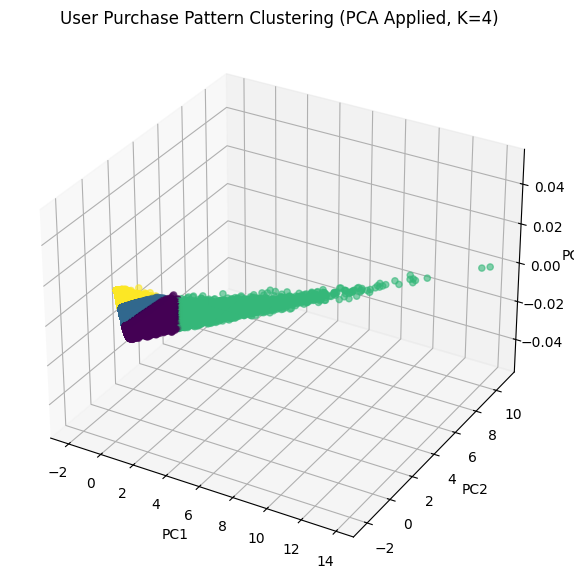

In [46]:
# ‚úÖ NaN Í∞íÏù¥ ÏûàÎäî ÌñâÎßå ÏÑ†ÌÉù (999Î°ú Î≥ÄÌôòÎêú Í∞í)
df_orders_nan = df_orders[df_orders["days_since_prior_order"] == 999]

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÎ¨∏ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
user_order_stats = df_orders_nan.groupby("user_id").agg({
    "order_number": "max",  # Ï¥ù Ï£ºÎ¨∏ ÌöüÏàò
    "days_since_prior_order": "mean"  # ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©
})

# ‚úÖ df_priorÏóê user_id Ï∂îÍ∞Ä (df_ordersÏôÄ Î≥ëÌï©)
ddf_prior = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïû¨Íµ¨Îß§Ïú® Í≥ÑÏÇ∞ (user_id Í∏∞Ï§Ä)
user_reorder_stats = ddf_prior.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ‚úÖ Ï∂îÍ∞Ä feature ÏÉùÏÑ± (ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï¥ù Ï£ºÎ¨∏ ÏÉÅÌíà Í∞úÏàò Ï∂îÍ∞Ä)
user_total_products = ddf_prior.groupby("user_id").size().reset_index(name="total_products")

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© (user_id Í∏∞Ï§Ä)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)
user_features = user_features.merge(user_total_products, on="user_id", how="left").fillna(0)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ ÌëúÏ§ÄÌôî
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id Ï†úÏô∏

# ‚úÖ feature Í∞ÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌôïÏù∏
sns.heatmap(pd.DataFrame(user_features_scaled, columns=user_features.columns[1:]).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ‚úÖ PCA Ï†ÅÏö© (Ï∞®Ïõê Ï∂ïÏÜå)
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features_scaled)

# ‚úÖ Ï£ºÏÑ±Î∂Ñ ÏÑ§Î™ÖÎ†• ÌôïÏù∏
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# ‚úÖ K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏµúÏ†ÅÌôî: n_clusters=3,4,5 ÎπÑÍµê
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ‚úÖ ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏÑ†ÌÉù (Í∏∞Î≥∏Ï†ÅÏúºÎ°ú n=4 ÏÇ¨Ïö©)
selected_k = 4
user_clusters = cluster_results[selected_k]

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû•
user_features["cluster"] = user_clusters

# ‚úÖ 3D ÏãúÍ∞ÅÌôî (PCA Ï†ÅÏö© ÌõÑ)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_pca[:, 0], user_pca[:, 1], user_pca[:, 2], c=user_clusters, cmap='viridis', alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"User Purchase Pattern Clustering (PCA Applied, K={selected_k})")
plt.show()


 Ïûò ÎÇòÎâòÏñ¥ÏßÄÏßÄ ÏïäÏùå. ÌïúÏ™Ω Î∞©Ìñ•ÏúºÎ°ú Í∑∏Î£πÌôîÍ∞Ä ÏπòÏö∞Ï≥êÏûàÏùå

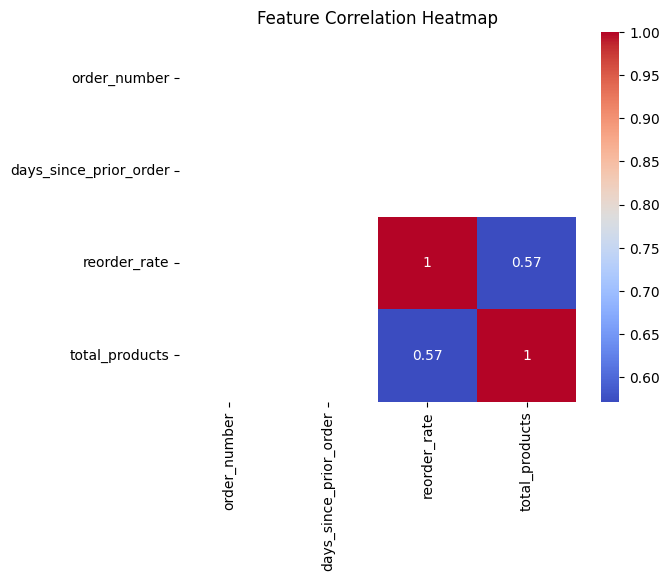

Explained Variance Ratio: [0.78582826 0.21417174 0.        ]


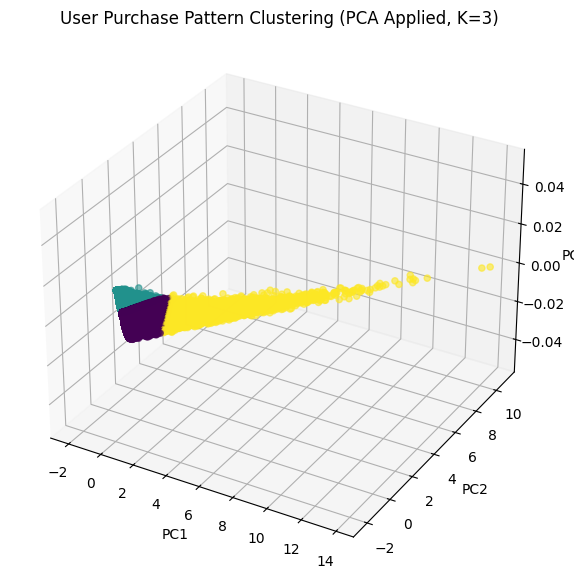

In [47]:
# ‚úÖ NaN Í∞íÏù¥ ÏûàÎäî ÌñâÎßå ÏÑ†ÌÉù (999Î°ú Î≥ÄÌôòÎêú Í∞í)
df_orders_nan = df_orders[df_orders["days_since_prior_order"] == 999]

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÎ¨∏ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
user_order_stats = df_orders_nan.groupby("user_id").agg({
    "order_number": "max",  # Ï¥ù Ï£ºÎ¨∏ ÌöüÏàò
    "days_since_prior_order": "mean"  # ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©
})

# ‚úÖ df_priorÏóê user_id Ï∂îÍ∞Ä (df_ordersÏôÄ Î≥ëÌï©)
ddf_prior = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïû¨Íµ¨Îß§Ïú® Í≥ÑÏÇ∞ (user_id Í∏∞Ï§Ä)
user_reorder_stats = ddf_prior.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ‚úÖ Ï∂îÍ∞Ä feature ÏÉùÏÑ± (ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï¥ù Ï£ºÎ¨∏ ÏÉÅÌíà Í∞úÏàò Ï∂îÍ∞Ä)
user_total_products = ddf_prior.groupby("user_id").size().reset_index(name="total_products")

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© (user_id Í∏∞Ï§Ä)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)
user_features = user_features.merge(user_total_products, on="user_id", how="left").fillna(0)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ ÌëúÏ§ÄÌôî
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id Ï†úÏô∏

# ‚úÖ feature Í∞ÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌôïÏù∏
sns.heatmap(pd.DataFrame(user_features_scaled, columns=user_features.columns[1:]).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ‚úÖ PCA Ï†ÅÏö© (Ï∞®Ïõê Ï∂ïÏÜå)
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features_scaled)

# ‚úÖ Ï£ºÏÑ±Î∂Ñ ÏÑ§Î™ÖÎ†• ÌôïÏù∏
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# ‚úÖ K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏµúÏ†ÅÌôî: n_clusters=3,4,5 ÎπÑÍµê
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ‚úÖ ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏÑ†ÌÉù (Í∏∞Î≥∏Ï†ÅÏúºÎ°ú n=4 ÏÇ¨Ïö©)
selected_k = 3
user_clusters = cluster_results[selected_k]

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû•
user_features["cluster"] = user_clusters

# ‚úÖ 3D ÏãúÍ∞ÅÌôî (PCA Ï†ÅÏö© ÌõÑ)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_pca[:, 0], user_pca[:, 1], user_pca[:, 2], c=user_clusters, cmap='viridis', alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"User Purchase Pattern Clustering (PCA Applied, K={selected_k})")
plt.show()


Í¥úÏ∞ÆÏïÑÏßÄÍ∏¥ ÌñàÎäîÎç∞ ÌïúÏ™Ω Î∞©Ìñ•ÏúºÎ°ú ÏπòÏö∞Ï≥êÏ†Ä ÏûàÏñ¥ÏÑú Ïù¥ÏÉÅÏπòÍ∞Ä Ïö∞Î†§Îê®

Ìï¥Îãπ Í∑∏ÎûòÌîÑ Í∏∞Î∞òÏúºÎ°ú ÏßÄÌîºÌã∞Îûë ÏÉÅÏùò Í≤∞Í≥º Í≥†Î†§ÎêòÎäî Í∞íÏù¥ Ï†ÅÏñ¥ÏÑú pca ÏïàÌïòÎäîÍ≤å Ï¢ãÏùÑ Í≤É Í∞ôÍ≥† ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÎèÑ Ï†ÅÌï©ÌïòÏßÄ ÏïäÎã§Í≥† ÌåêÎã®.
‚úÖ K-Means (Í∏∞Ï°¥ Î∞©Ïãù)
‚úÖ DBSCAN (Î∞ÄÎèÑ Í∏∞Î∞ò)
‚úÖ Hierarchical Clustering (Í≥ÑÏ∏µÏ†Å Íµ∞ÏßëÌôî + Îç¥ÎìúÎ°úÍ∑∏Îû® ÏãúÍ∞ÅÌôî)
ÏöîÎ†áÍ≤å 3Í∞ÄÏßÄ Ï∂îÏ≤úÎ∞õÏùå. Ïó¨Í∏∞ÍπåÏßÄ ÏßÑÌñâ

### Ïã†Í∑úÍ≥†Í∞ù + Í∑∏ÎÉ• Í≥†Í∞ù Ï†ÑÎ∂Ä Í≥†Î†§Ìï®

Í≤ΩÎØºÎãòÏù¥ ÏßÑÌñâÌïòÏã† mean()Í∞íÏúºÎ°ú Ïû¨Î∂ÑÎ•òÌïú Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú ÏßÑÌñâ. ÏúÑÏóê ÏßÑÌñâÌñàÎçòÍ±∞ Îã§ Î¶¨ÏÖãÌïòÍ≥† ÏïÑÎû´ Î∂ÄÎ∂ÑÎßå Îã§Ïãú ÏßÑÌñâÌï¥Ïïº Î∂ÑÏÑù Í∞ÄÎä•

In [48]:
#first_purchaseÎùºÎäî Ï≤´Íµ¨Îß§ ÌôïÏù∏Ïö© Ïª¨Îüº Ï∂îÍ∞ÄÌïòÏó¨ days_since_prior_orderÍ∞Ä NaNÏù¥Î©¥ 1, ÏïÑÎãàÎ©¥ 0ÏùÑ Ï†ÄÏû•
df_orders["first_purchase"] = df_orders["days_since_prior_order"].isna().astype(int)

#ÌèâÍ∑†Í≥º Ï§ëÏïôÍ∞í ÌôïÏù∏
df_orders["days_since_prior_order"].describe().apply(lambda x: f"{x:,.2f}")

#ÎπÑÎåÄÏπ≠ Î∂ÑÌè¨Ïù¥ÎØÄÎ°ú Í≤∞Ï∏°Ïπò Ï§ëÏïôÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
df_orders["days_since_prior_order"] = df_orders["days_since_prior_order"].fillna(df_orders["days_since_prior_order"].median())

 kmeans = KMeans(n_clusters=4, random_state=42) Ïù¥Í±∞ Î™áÍ∞úÎ°ú ÎÇòÎàåÏßÄ Í≤∞Ï†ïÌïòÎäîÍ±¥Îç∞ 
 #### 3,4,5 Ìï¥Î≥∏ Í≤∞Í≥º 4Í∞úÍ∞Ä Ï†úÏùº Ïú†ÏùòÎØ∏Ìïú Î∂ÑÎ•ò.
 Í∑ºÍ±∞ÎêòÎäî ÏΩîÎìú ÏïÑÏßÅ Î™ªÎΩëÏùå

In [49]:
# -------------------------
# 1. ÏÇ¨Ïö©Ïûê Íµ¨Îß§ Ìå®ÌÑ¥ Í∏∞Î∞ò PCA + ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ [Ï†ÑÎ∂Ä Îã§]
# -------------------------

# ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÎ¨∏ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
user_order_stats = df_orders.groupby("user_id").agg({
    "order_number": "max",  # Ï¥ù Ï£ºÎ¨∏ ÌöüÏàò
    "days_since_prior_order": "mean"  # ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©
}).fillna(999)

# ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïû¨Íµ¨Îß§Ïú® Í≥ÑÏÇ∞
user_reorder_stats = df_prior.groupby("order_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.groupby("order_id")["reordered"].mean()

# Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
user_features = user_order_stats.copy()
user_features["reorder_rate"] = user_reorder_stats

# NaN Í∞í Ï≤òÎ¶¨
user_features.fillna(0, inplace=True)  # NaNÏùÑ 0ÏúºÎ°ú ÎåÄÏ≤¥

# Îç∞Ïù¥ÌÑ∞ ÌëúÏ§ÄÌôî
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)

# PCA Ï†ÅÏö©
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_features_scaled)

# K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
kmeans = KMeans(n_clusters=4, random_state=42)
user_clusters = kmeans.fit_predict(user_pca)

# ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï∂îÍ∞Ä
user_features["cluster"] = user_clusters

# ÏãúÍ∞ÅÌôî
plt.scatter(user_pca[:, 0], user_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("User Purchase Pattern Clustering")
plt.colorbar(label="Cluster")
plt.show()

